In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [12]:
%cd ../code/pipeline/export

/code/pipeline/export


In [13]:
import to_s3

ModuleNotFoundError: No module named 'pipeline'

In [2]:
%cd

/root


In [3]:
import multiprocessing as mp
pool = mp.Pool(8)

In [4]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd

import dill
import scipy

from to_s3_util import export_df_and_upload
from s3_psth_z_score import compute_unit_firing_binned_by_latent_variable

# cache_folder = '~/s3-drive/report/st_cache/'
# cache_folder = '/home/jupyter/s3-drive/export/'

cache_folder = '/root/capsule/data/s3/export/'

session_keys =  dill.load(open(cache_folder + 'session_keys.pkl', 'rb'))
session_keys

[{'subject_id': 473360, 'session': 49},
 {'subject_id': 473360, 'session': 50},
 {'subject_id': 473360, 'session': 51},
 {'subject_id': 473360, 'session': 52},
 {'subject_id': 473361, 'session': 47},
 {'subject_id': 473361, 'session': 57},
 {'subject_id': 473361, 'session': 59},
 {'subject_id': 473361, 'session': 60},
 {'subject_id': 482353, 'session': 33},
 {'subject_id': 482353, 'session': 34},
 {'subject_id': 482353, 'session': 36},
 {'subject_id': 482353, 'session': 37},
 {'subject_id': 482353, 'session': 42},
 {'subject_id': 482353, 'session': 43},
 {'subject_id': 482353, 'session': 45},
 {'subject_id': 494691, 'session': 17},
 {'subject_id': 494691, 'session': 18}]

# Generate z-scores tuning across deltaQ, sumQ, rpe, etc.

## Sort by different quatiles of latent variable, generate z-score firing for each unit

In [3]:
session_key = session_keys[-2]

In [5]:
session_key = {'subject_id': 473361, 'session': 60}

In [6]:
df_aligned_spikes = dill.load(open(cache_folder + f'{session_key["subject_id"]}_{session_key["session"]}_aligned_spike_counts.pkl', 'rb'))
df_behavior = dill.load(open(cache_folder + f'{session_key["subject_id"]}_{session_key["session"]}_behavior.pkl', 'rb'))

In [41]:
    # def compute_unit_firing_binned_by_latent_variable(df_aligned_spikes,
    #                                                 df_behavior,
    #                                                 align_to='iti_start',
    #                                                 time_win = [0, 2],
    #                                                 latent_name='relative_action_value_lr',
    #                                                 latent_variable_offset=0,   # <=0. e.g., -1 means use the latent variable from trial-1
    #                                                 latent_bins=None,                                                  
    #                                                 if_z_score_latent=True,
    #                                                 ):
    '''
    df_aligned_spikes --> df_unit_latent_bin_firing (raw)
    '''
    
    
    align_to='go_cue'
    time_win = [-2, 0]
    latent_name='rpe'
    latent_variable_offset=0  # <=0. e.g., -1 means use the latent variable from trial-1
    latent_bins=None                                                  
    if_z_score_latent=False
    if_use_quantile_for_latent=True
    n_quantile=6
    
    
    aligned_spikes = df_aligned_spikes.aligned_firings[align_to]
    ts = df_aligned_spikes.times[align_to]

    valid_trials = df_aligned_spikes.trials[align_to]  # may skip ignored trials
    latent_values = df_behavior.query('trial in @valid_trials')[latent_name]
    choices =  df_behavior.query('trial in @valid_trials')['choice_lr']
    
    # offset latent variable
    assert latent_variable_offset <= 0, 'invalid latent_variable_offset'
    latent_values = latent_values.iloc[:len(latent_values)+latent_variable_offset]
    choices = choices.iloc[:len(choices)+latent_variable_offset]  # For before go cue, this becomes the previous trial
    aligned_spikes = aligned_spikes[:, -latent_variable_offset:, :]


In [42]:
    # z-score latent variable
    if if_z_score_latent:
        latent_values = scipy.stats.zscore(latent_values.astype(float), nan_policy='omit')
        
    # determine bins for latent variable
    if if_use_quantile_for_latent:
        out, latent_bins = pd.qcut(latent_values.astype(float), q=n_quantile, retbins=True, labels=False, duplicates='drop')
        latent_bin_centers = np.linspace(1/n_quantile/2, 1-1/n_quantile/2, n_quantile)
    else:
        if latent_bins is None:
            latent_bins = np.linspace(-3, 3, 20) if if_z_score_latent else np.linspace(np.min(latent_values), np.max(latent_values), 20)      
        latent_bin_centers = (latent_bins[:-1] + latent_bins[1:]) / 2

    # compute average firing rate in the given time window (N_neurons * N_trials)
    aligned_aver_firing = np.mean(aligned_spikes[:, :, (time_win[0] <= ts) & (ts < time_win[1])], axis=2) / df_aligned_spikes.bin_size  # spike / s

    # split trials according to the previous and next choice
    choice_mapping = dict(  all_choice = pd.Series(True, index=choices.index),
                            previous_choice_l = choices == 0,  # For before go cue, since it is already offseted, this becomes the previous trial; for after go cue or iti start, this is the trial that just happened
                            previous_choice_r = choices == 1,
                            next_choice_l = (choices == 0).shift(-1).fillna(False),  # choice immediately AFTER 'before go cue', but the choice of the next trial of "after go cue" / "iti start" etc.
                            next_choice_r = (choices == 1).shift(-1).fillna(False))
    
    # for each choice split, compute aver z-score
    dfs = []


    for choice_group, choice_filter in choice_mapping.items():
        # sort firing according to bins of latent variable (N_bins list of N_neurons * N_trials in the bin)
        latent_binned_firing = [aligned_aver_firing[:, (low <= latent_values) & (latent_values < high) & choice_filter] 
                               for low, high in zip(latent_bins[:-1], latent_bins[1:])]
            
        # for each unit, mean and sem across selected trials (N_neurons * N_bins)
        df_mean = pd.DataFrame(np.array(list(map(lambda x: np.nanmean(x, axis=1), latent_binned_firing))).T, 
                                 index=pd.MultiIndex.from_frame(pd.DataFrame(df_aligned_spikes.unit_keys)), 
                                 columns=pd.MultiIndex.from_tuples([(choice_group, 'mean', center) for center in latent_bin_centers], names=['choice_group', 'stats', f"{latent_name}{'_z_score' if if_z_score_latent else ''}"]),
                                 )
        df_sem = pd.DataFrame(np.array(list(map(lambda x: scipy.stats.sem(x, axis=1), latent_binned_firing))).T,
                                 index=pd.MultiIndex.from_frame(pd.DataFrame(df_aligned_spikes.unit_keys)), 
                                 columns=pd.MultiIndex.from_tuples([(choice_group, 'sem', center) for center in latent_bin_centers], names=['choice_group', 'stats', f"{latent_name}{'_z_score' if if_z_score_latent else ''}"]),
                                 )
        dfs.extend([df_mean, df_sem])
        
    df_unit_latent_bin_firing = pd.concat(dfs, axis=1)

    # for each unit, compute pearson r and p, using all choices
    pearson_r_p = [scipy.stats.pearsonr(x[~np.isnan(x)], latent_bins[:-1][~np.isnan(x)])
                   if np.sum(~np.isnan(x)) >= 2
                   else (np.nan, np.nan) 
                   for x in np.array(df_mean)]
    pearson_r, pearson_p = zip(*pearson_r_p)
    df_unit_latent_bin_firing['r'] = pearson_r
    df_unit_latent_bin_firing['p'] = pearson_p
    
    # compute z_score mean and std using average psth aligned to go_cue (spike / s)
    aver_psth = np.mean(df_aligned_spikes.aligned_firings['go_cue'], axis=1) / df_aligned_spikes.bin_size
    z_mean = np.mean(aver_psth, axis=1)
    z_std = np.std(aver_psth, axis=1)
    df_unit_latent_bin_firing['z_mean'] = z_mean
    df_unit_latent_bin_firing['z_std'] = z_std
    
    # store meta info
    df_unit_latent_bin_firing._metadata = dict(align_to=align_to, time_win=time_win, latent_name=latent_name, 
                                          latent_variable_offset=latent_variable_offset, if_z_score_latent=if_z_score_latent)
    
    # return df_unit_latent_bin_firing

ValueError: Shape of passed values is (91, 5), indices imply (91, 6)

In [5]:
def compute_group_tuning(df_unit_latent_bin_firing, 
                         unit_keys=None,
                         if_z_score_firing=True,   # z-score
                         significance_level=None,  # if None, all cells
                         if_flip_tuning=True # auto flip here, within the selected unit_keys, where users controls significance etc.
                         ):
    
    if unit_keys is None:
        unit_keys = df_unit_latent_bin_firing.index
        
    if significance_level is not None:
        unit_keys = unit_keys[df.loc[unit_keys].p < significance_level]
    
    selected_tuning = df_unit_latent_bin_firing.loc[unit_keys, 'mean']
    z_mean = df_unit_latent_bin_firing.loc[unit_keys, 'z_mean']
    z_std = df_unit_latent_bin_firing.loc[unit_keys, 'z_std']
    
    if if_z_score_firing:
        #  selected_tuning = selected_tuning.apply(scipy.stats.zscore, axis=1, nan_policy='omit')  # using mean and binned activity (not full dynamic range of the neuron!)
        selected_tuning = selected_tuning.sub(z_mean, axis=0).div(z_std, axis=0)       # using dynamic range of the neuron (average psth aligned to go_cue)
        
    if if_flip_tuning:
        to_flip = df_unit_latent_bin_firing['r'] < 0
        selected_tuning.loc[to_flip] = np.array(selected_tuning.loc[to_flip])[:, ::-1]

    tuning_mean = selected_tuning.mean(axis=0)
    tuning_sem = selected_tuning.sem(axis=0)      
    
    return tuning_mean, tuning_sem, selected_tuning


def plot_population_tuning(tuning_mean, tuning_sem, selected_tuning, **kwargs):
    plt.subplots(1, 1)
    plt.errorbar(tuning_mean.index, tuning_mean, tuning_sem, lw=2, capsize=5, elinewidth=2, markeredgewidth=2)
    # plt.plot(tuning_mean.index, selected_tuning.T, c='gray', ls='-', alpha=0.1)
    plt.title(f'n = {selected_tuning.shape[0]}, {[kwargs[x] for x in ["latent_name", "align_to", "time_win"]]}')

   

## Compute z-score for all units * z-score settings

In [31]:
df_unit_latent_bin_firing

choice_group                                                        all_choice  \
stats                                                                     mean   
relative_action_value_lr_z_score                           -2.8421052631578947   
subject_id session insertion_number clustering_method unit                       
494691     17      1                kilosort2         1                    NaN   
                                                      5                    NaN   
                                                      9                    NaN   
                                                      14                   NaN   
                                                      18                   NaN   
...                                                                        ...   
                   3                kilosort2         1148                 NaN   
                                                      1153                 NaN   
                                                      1158                 NaN   
                                                      1161                 NaN   
                                                      1162                 NaN   

choice_group                                                                   \
stats                                                                           
relative_action_value_lr_z_score                           -2.526315789473684   
subject_id session insertion_number clustering_method unit                      
494691     17      1                kilosort2         1                   NaN   
                                                      5                   NaN   
                                                      9                   NaN   
                                                      14                  NaN   
                                                      18                  NaN   
...                                                                       ...   
                   3                kilosort2         1148                NaN   
                                                      1153                NaN   
                                                      1158                NaN   
                                                      1161                NaN   
                                                      1162                NaN   

choice_group                                                                    \
stats                                                                            
relative_action_value_lr_z_score                           -2.2105263157894735   
subject_id session insertion_number clustering_method unit                       
494691     17      1                kilosort2         1                    NaN   
                                                      5                    NaN   
                                                      9                    NaN   
                                                      14                   NaN   
                                                      18                   NaN   
...                                                                        ...   
                   3                kilosort2         1148                 NaN   
                                                      1153                 NaN   
                                                      1158                 NaN   
                                                      1161                 NaN   
                                                      1162                 NaN   

choice_group                                                                    \
stats                                                                            
relative_action_value_lr_z_score                           -1.8947368421052633   
subject_id session insertion_number clustering_method unit                  

In [7]:
z_tuning_mappper = {'dQ_go_cue_before_2': dict(align_to='go_cue', time_win=[-2, 0], latent_name='relative_action_value_lr', latent_bins=np.linspace(-3, 3, 20), if_z_score_latent=True, latent_variable_offset=-1),
                    'dQ_iti_start_before_1': dict(align_to='iti_start', time_win=[-1, 0], latent_name='relative_action_value_lr', latent_bins=np.linspace(-3, 3, 20), if_z_score_latent=True),
                    'dQ_iti_start_after_2': dict(align_to='iti_start', time_win=[0, 2], latent_name='relative_action_value_lr', latent_bins=np.linspace(-3, 3, 20), if_z_score_latent=True),
                    
                    'sumQ_go_cue_before_2': dict(align_to='go_cue', time_win=[-2, 0], latent_name='total_action_value', latent_bins=np.linspace(-3, 3, 20), if_z_score_latent=True, latent_variable_offset=-1),
                    'sumQ_iti_start_before_1': dict(align_to='iti_start', time_win=[-1, 0], latent_name='total_action_value', latent_bins=np.linspace(-3, 3, 20), if_z_score_latent=True),
                    'sumQ_iti_start_after_2': dict(align_to='iti_start', time_win=[0, 2], latent_name='total_action_value', latent_bins=np.linspace(-3, 3, 20), if_z_score_latent=True),
                    
                    'rpe_go_cue_before_2': dict(align_to='go_cue', time_win=[-2, 0], latent_name='rpe', latent_bins=np.linspace(-1, 1, 20), if_z_score_latent=False, latent_variable_offset=-1),
                    'rpe_choice_after_2': dict(align_to='choice', time_win=[0, 2], latent_name='rpe', latent_bins=np.linspace(-1, 1, 20), if_z_score_latent=False),                    
                    'rpe_iti_start_before_1': dict(align_to='iti_start', time_win=[-1, 0], latent_name='rpe', latent_bins=np.linspace(-1, 1, 20), if_z_score_latent=False),
                    'rpe_iti_start_after_2': dict(align_to='iti_start', time_win=[0, 2], latent_name='rpe', latent_bins=np.linspace(-1, 1, 20), if_z_score_latent=False),
                   }

In [8]:
def compute_one_session_z_score(session_key):
    df_aligned_spikes = dill.load(open(cache_folder + f'{session_key["subject_id"]}_{session_key["session"]}_aligned_spike_counts.pkl', 'rb'))
    df_behavior = dill.load(open(cache_folder + f'{session_key["subject_id"]}_{session_key["session"]}_behavior.pkl', 'rb'))
    
    this_session = {}
    for name, setting in z_tuning_mappper.items():
        # print(name)
        this_session[name] = compute_unit_firing_binned_by_latent_variable(df_aligned_spikes, df_behavior, **setting)
    
    print(f'{session_key} done')
    return this_session

In [6]:
all_session = []
for sess in session_keys:
    print(sess)
    all_session.append(compute_one_session_z_score(sess))
    

{'subject_id': 473360, 'session': 49}


: 

: 

In [12]:
results = [pool.apply_async(compute_one_session_z_score, args=(sess,)) for sess in session_keys]
all_session = [r.get() for r in results]

Process ForkPoolWorker-1:
Process ForkPoolWorker-2:
Process ForkPoolWorker-3:
Process ForkPoolWorker-6:
Process ForkPoolWorker-4:
Process ForkPoolWorker-5:
Process ForkPoolWorker-8:
Process ForkPoolWorker-7:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File 

KeyboardInterrupt: 

In [27]:
all_session[0].keys()

dict_keys(['dQ_go_cue_before_2', 'dQ_iti_start_before_1', 'dQ_iti_start_after_2', 'sumQ_go_cue_before_2', 'sumQ_iti_start_before_1', 'sumQ_iti_start_after_2', 'rpe_go_cue_before_2', 'rpe_choice_after_2', 'rpe_iti_start_before_1', 'rpe_iti_start_after_2'])

### Export all z-score to pickle

In [42]:
for this_setting_name in z_tuning_mappper:
    dfs_for_this_setting = []
    for dfs_this_session in all_session:
        dfs_for_this_setting.append(dfs_this_session[this_setting_name])
        
    df_this_setting_all_session = pd.concat(dfs_for_this_setting)
    df_this_setting_all_session._metadata = dfs_this_session[this_setting_name]._metadata
    fname = f'z_score_all_{this_setting_name}.pkl'
    df_this_setting_all_session.to_pickle(cache_folder + fname)

In [43]:
df_this_setting_all_session._metadata

{'align_to': 'iti_start',
 'time_win': [0, 2],
 'latent_name': 'rpe',
 'latent_variable_offset': 0,
 'if_z_score_latent': False}

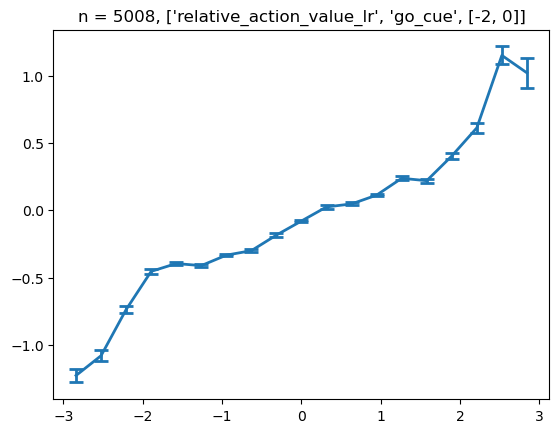

In [44]:
df_this_setting_all_session = pd.read_pickle(cache_folder + 'z_score_all_dQ_go_cue_before_2.pkl')
plot_population_tuning(*compute_group_tuning(df_this_setting_all_session, 
                                                unit_keys=None, #df.index[df.r > 0], 
                                                if_z_score_firing=True,
                                                significance_level=None,
                                                if_flip_tuning=False if df_this_setting_all_session._metadata['latent_name'] == 'rpe' else True), **df_this_setting_all_session._metadata)

dQ_go_cue_before_2
dQ_iti_start_before_1
dQ_iti_start_after_2
sumQ_go_cue_before_2
sumQ_iti_start_before_1
sumQ_iti_start_after_2
rpe_go_cue_before_2
rpe_choice_after_2
rpe_iti_start_before_1
rpe_iti_start_after_2


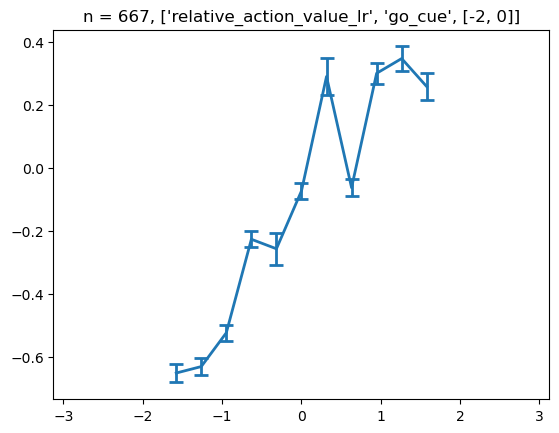

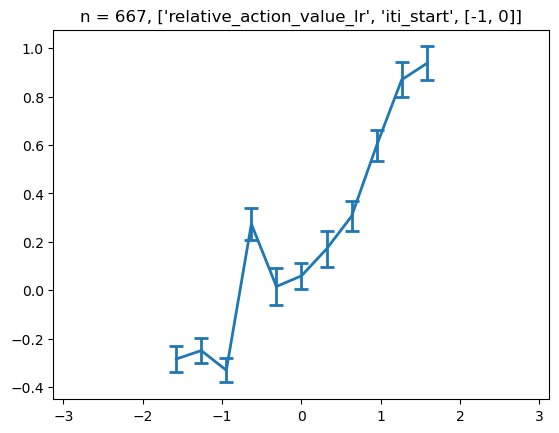

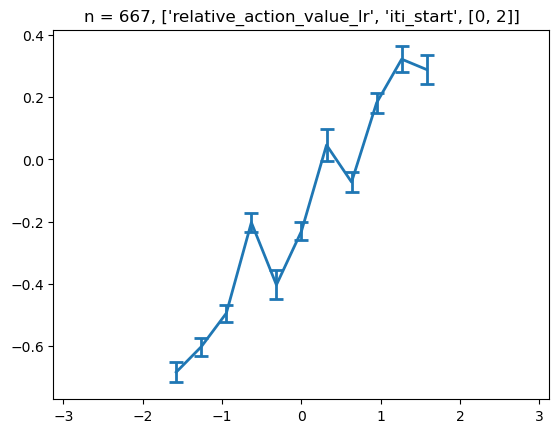

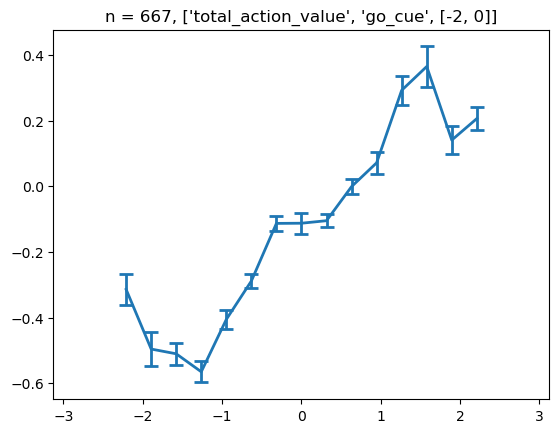

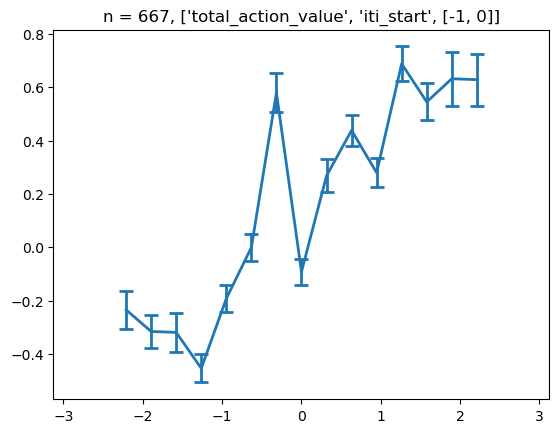

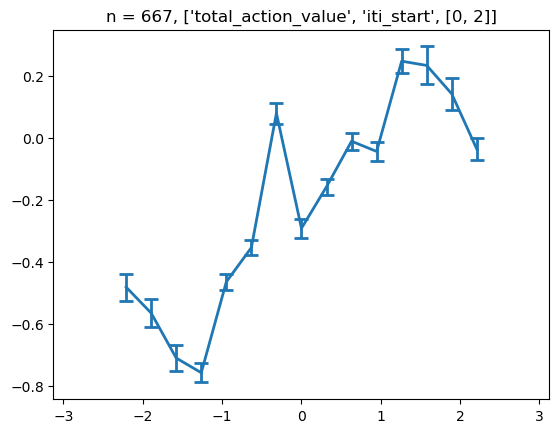

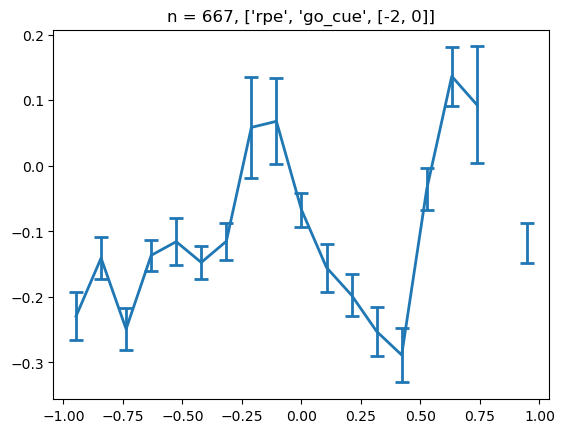

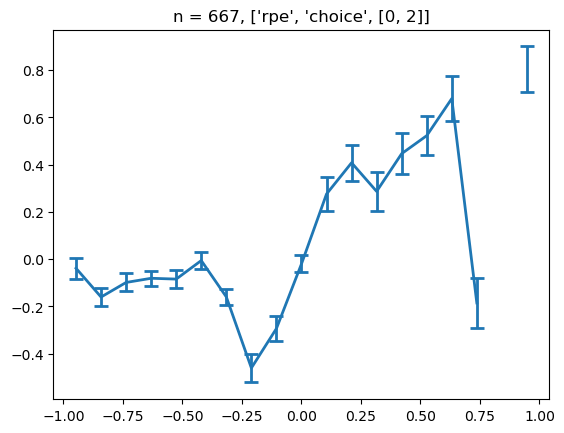

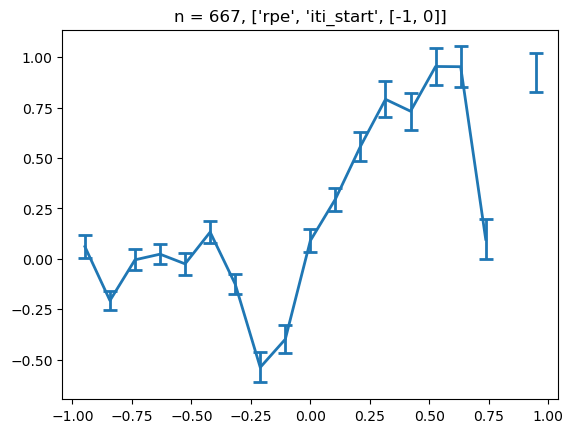

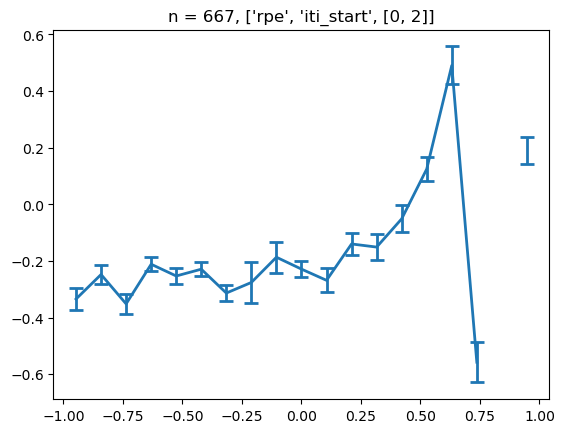

In [11]:
for name, setting in z_tuning_mappper.items():
    print(name)
    df = compute_unit_firing_binned_by_latent_variable(df_aligned_spikes, df_behavior, **setting)
    plot_population_tuning(*compute_group_tuning(df, 
                                                unit_keys=None, #df.index[df.r > 0], 
                                                if_z_score_firing=True,
                                                significance_level=None,
                                                if_flip_tuning=False if df._metadata['latent_name'] == 'rpe' else True), **df._metadata)

In [12]:
df._metadata

{'align_to': 'iti_start',
 'time_win': [0, 2],
 'latent_name': 'rpe',
 'latent_variable_offset': 0,
 'if_z_score_latent': False}

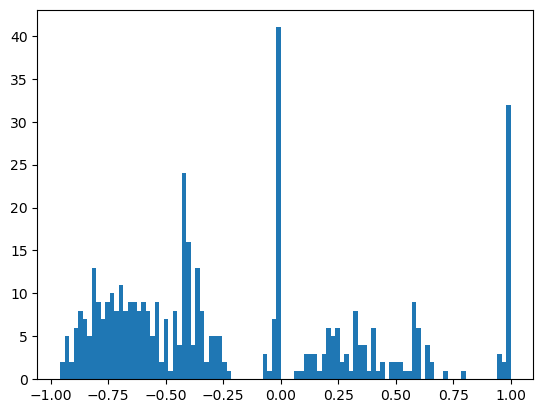

In [143]:
plt.hist(df_behavior['rpe'].astype(float), 100);

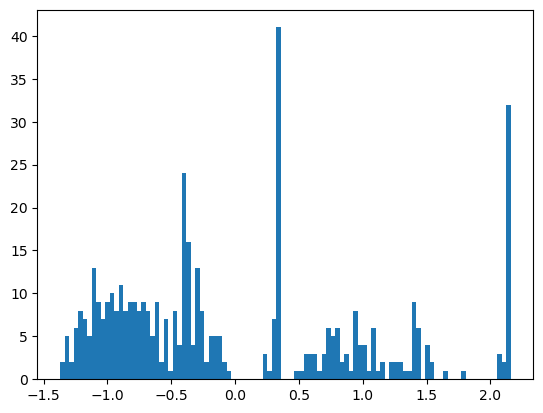

In [87]:
plt.hist(scipy.stats.zscore(df_behavior['rpe'].astype(float), nan_policy='omit'), 100);

In [54]:
unit_keys = df_unit_latent_bin_firing.index
selected_tuning = df_unit_latent_bin_firing.loc[unit_keys, 'mean']
if if_z_score_firing:
    selected_tuning = selected_tuning.apply(scipy.stats.zscore, axis=1, nan_policy='omit')
    
if if_flip_tuning:
    to_flip = df_unit_latent_bin_firing['r'] < 0
    selected_tuning.loc[to_flip] = np.array(selected_tuning.loc[to_flip])[:, ::-1]

tuning_mean = selected_tuning.mean(axis=0)
tuning_sem = selected_tuning.sem(axis=0)


In [ ]:
# average and sem across significant neurons only, separately for negative and positive
sign_level = 0.05
sign_p = pearson_p < sign_level
neg_r = (pearson_r < 0)
pos_r = (pearson_r >= 0)

pop_bin_neg_r_raw_firing_mean = np.mean(unit_bin_firing_mean[neg_r & sign_p, :], axis=0)
pop_bin_neg_r_raw_firing_sem = scipy.stats.sem(unit_bin_firing_mean[neg_r & sign_p, :], axis=0)
pop_bin_pos_r_raw_firing_mean = np.mean(unit_bin_firing_mean[pos_r & sign_p, :], axis=0)
pop_bin_pos_r_raw_firing_sem = scipy.stats.sem(unit_bin_firing_mean[pos_r & sign_p, :], axis=0)


unit_bin_flipped_firing_mean = np.concatenate([unit_bin_firing_mean[pos_r, :], 
                                               unit_bin_firing_mean[neg_r, ::-1]], 
                                               axis=0)

pop_bin_sign_flipped_raw_firing_mean = np.mean(, 
                                               axis=0)